<a href="https://colab.research.google.com/github/Shubhang-verma8/assignment-1-Shubhang-verma8/blob/ML/infection_area_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install imgaug                     # for image augmentation

In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 3.9MB 50.9MB/s 
     |████████████████████████████████| 450kB 56.2MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=3e3657d7bcbc20fbaa326f2ea4762ce7419e2e1eebf619a7a9c7bdb0c57aa041
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
!pip install keras_applications==1.0.8

In [ ]:
!pip install image-classifiers==1.0.0

In [ ]:
!pip install efficientnet==1.0.0

In [ ]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 5.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install -U segmentation-models    # ONLY used for dice metric and IOU metric computation, models are made from scratch

In [ ]:
!pip install plot-metric                 # ONLY used for ROC curve, confusion matrix plotting

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.utils import class_weight

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
GPU is available


In [ ]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


* Setting up environment to connect kaggle and colab

In [ ]:
os.environ['KAGGLE_USERNAME'] = "shubhangverma" # username from the json file
os.environ['KAGGLE_KEY'] = "1cc87824f2502cd32df31fad4c597e8b" # key from the json file

* kaggle dataset api

In [ ]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:40<00:00, 24.9MB/s]
100% 1.03G/1.03G [00:41<00:00, 27.0MB/s]


In [ ]:
os.listdir()

['.config', 'covid19-ct-scans.zip', 'sample_data']

* Extracting zip file here

In [ ]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [ ]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [ ]:
raw_data.shape

(20, 4)

* img_size is the preferred image size to which the image is to be resized

In [ ]:
img_size = 512

* Used (CLAHE) Contrast Limited Adaptive Histogram Equalization to enhance the contrast of the images since medical images suffer a lot from the contrast problems.
* Here Clip limit and the grid size are the hyperparameters to tune, generally clip limit should be between 2 to 4 as higher clip limit won't clip most of the histogram and treat it as AHE.
* Higher clip limit might not even prevent the image from overamplifying the noise (the core advantage the CLAHE gives over AHE)

* demo is a boolean variable, if 1 then giving the ability to plot the before and image after enhancement along with their respective histogram plots.

In [ ]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

* The images possess a lot of black space containing nothing and parts in which we are not interested like diaphragm below lungs. They will take the valuable RAM and also the unnecessary convolutions (computing power)
* A possible solution is cropping the images and taking out the Region Of Interest (ROI) as per problem statement and use case.
* Other pros are that we can now have greater area of ROI in the same resolution.
* For cropping, though we can slice the rows and columns using trial and error but that process would be limited to this dataset only. 
* If I input the same images with the lungs translated vertically a bit, the above technique would fail miserably and would rather crop the lungs too.
* So, a more better approach is to draw contours over the image and then cropping out the rectangle with the biggest contour with the largest area. 
* The contour (largest closed boundary) with the largest area would be the contour covering both the lungs.
* This will require thresholding as a prior step. After plotting the histogram of the images, the images were found near bimodal i.e. roughly two peaks. So, used the Otsu's method of binarization
* In global thresholding, we can use an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically and returns it.

* Another important point is while cropping a CT scan we have to make sure that its corresponding segmentation map is also cropped by same limits otherwise pixel level labeling will go wrong and the model might map a good area with an infectious area and vice versa which we don't want.
* So, in order to preserve the 4 end points, I am using a list by the name "points" for the same.

In [ ]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

* Dataset contain 20 files of .nii type, though each file contained multiple channels or silces each as a separate gray scale image.
* Total slices are 3520. These have been sliced out by 20% in the front and by 20% in the last of each file since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
* Also, images had pixel values from -998 to 1000+. Did min-max scaling.

In [ ]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [ ]:
all_points1 = []
all_points2 = []

In [ ]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 

        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [ ]:
cts = []
lungs = []
infections = []

In [ ]:
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


* See the following fully processed sample

(250, 250) (250, 250)


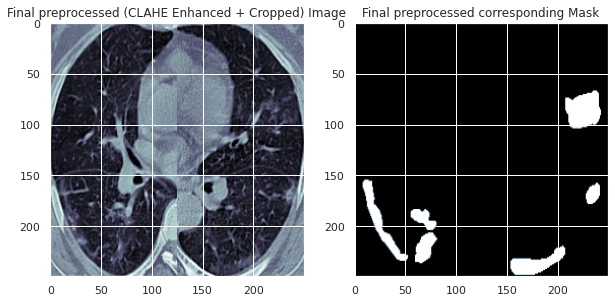

In [ ]:
x = 100

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

(250, 250) (250, 250)


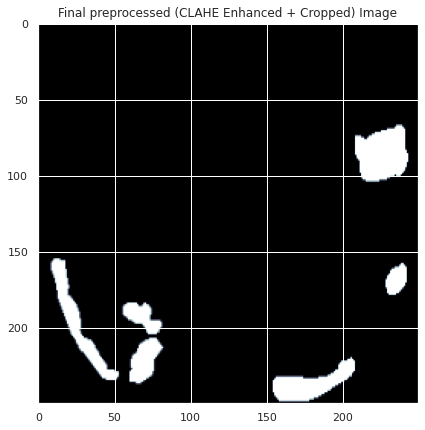

In [ ]:
x = 100

rcParams['figure.figsize'] = 7, 7

plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

print(infections[x].shape, cts[x].shape)

* Also, figuring out that 498 slices were of complete black masks i.e. no infection. For right now, kept out as didn't want to bother the segmentation model with this. 
* A better approach would be to make a sub-task and use that sub-task's output as input in our main task. Train a separate binary classifier to classify the CT scan as complete black or not, then the not ones to be passed from the segmentation model trained in this notebook.

In [ ]:
no_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

Number of complete black masks : 497


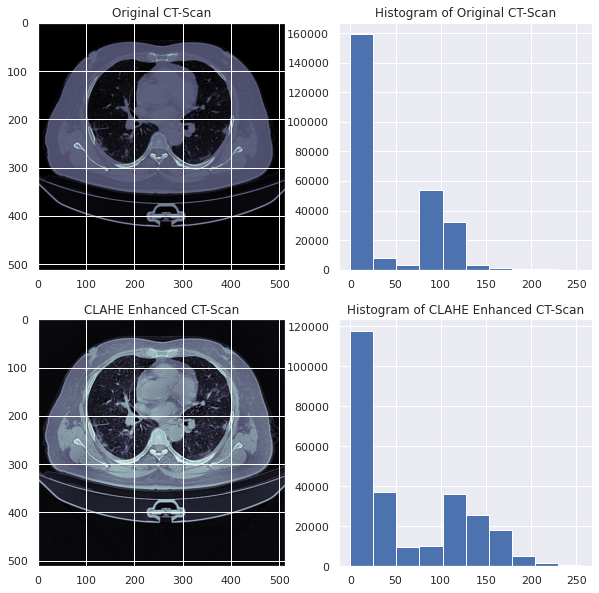

In [ ]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[100], demo = 1)

In [ ]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [ ]:
new_dim = 224

In [ ]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [ ]:
cts = np.array(cts)
infections = np.array(infections)

In [ ]:
new_cts = np.uint8(cts)
new_infections = np.uint8(infections)

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [ ]:
no_of_aug_imgs = 50
random_indices = np.random.randint(0, new_cts.shape[0], size=no_of_aug_imgs)
sample_new_cts = new_cts[random_indices]
sample_new_infections = new_infections[random_indices]

In [ ]:
new_cts_aug, new_infections_aug = seq(images=sample_new_cts, 
                              segmentation_maps=sample_new_infections)

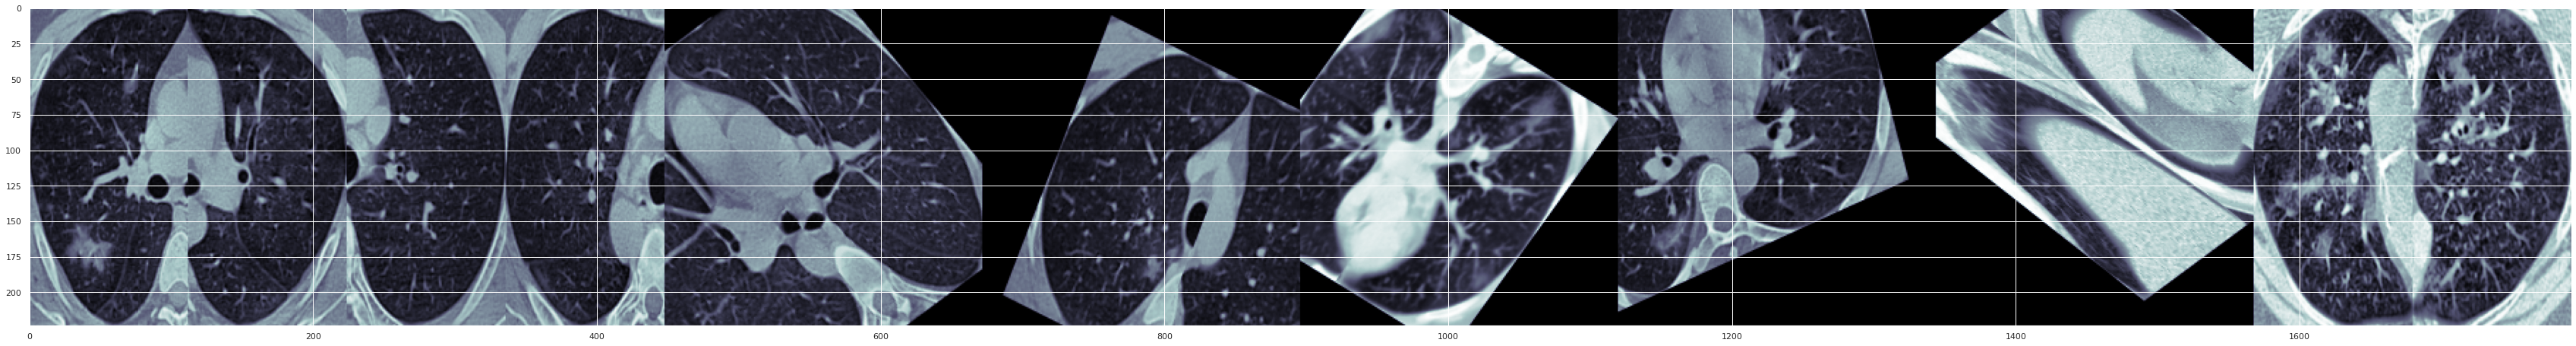

In [ ]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = new_cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

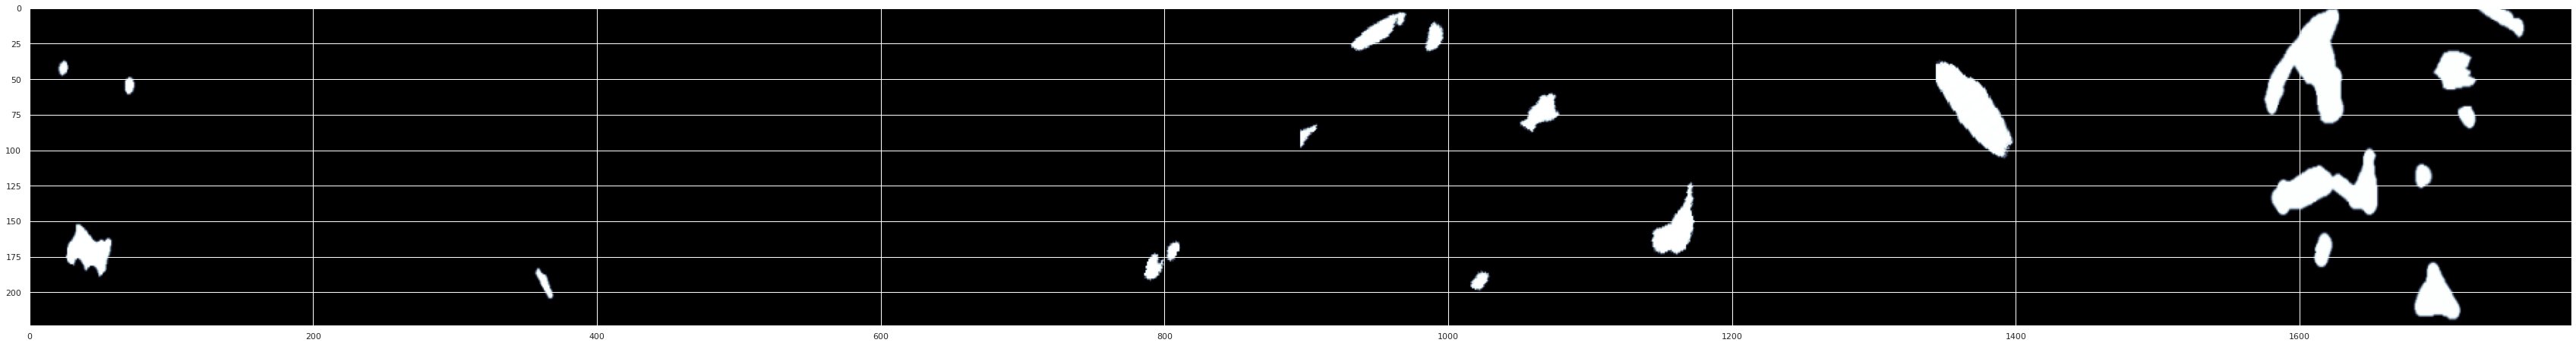

In [ ]:
cells2 = new_infections_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [ ]:
print(new_cts_aug.shape, new_infections_aug.shape)

(50, 224, 224) (50, 224, 224)


In [ ]:
new_cts_aug = new_cts_aug/255
new_infections_aug = new_infections_aug/255
new_cts_aug = new_cts_aug.reshape(len(new_cts_aug), new_dim, new_dim, 1)
new_infections_aug = new_infections_aug.reshape(len(new_infections_aug), new_dim, new_dim, 1)

In [ ]:
new_cts = new_cts/255
new_infections = new_infections/255

In [ ]:
new_cts = new_cts.reshape(len(new_cts), new_dim, new_dim, 1)
new_infections = new_infections.reshape(len(new_infections), new_dim, new_dim, 1)

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0].reshape(img_size,img_size), cmap='bone')
    # plt.imshow(array_list[1].reshape(img_size, img_size), alpha=0.5, cmap=color_map)
    # plt.title('Lung and Infection Mask')

#     plt.subplot(1,4,4)
#     plt.imshow(array_list[0], cmap='bone')
#     plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
#     plt.title('Lung and Infection Mask')

    plt.show()

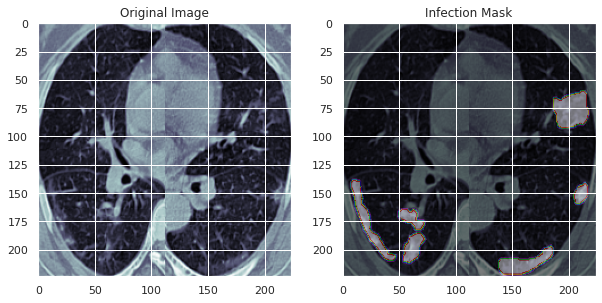

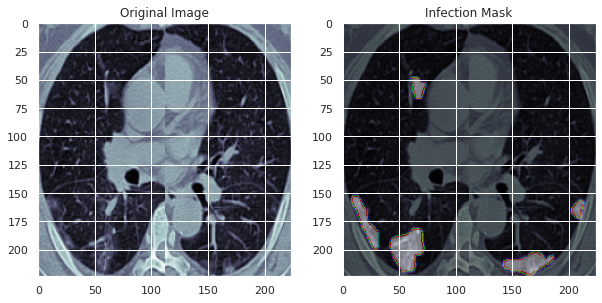

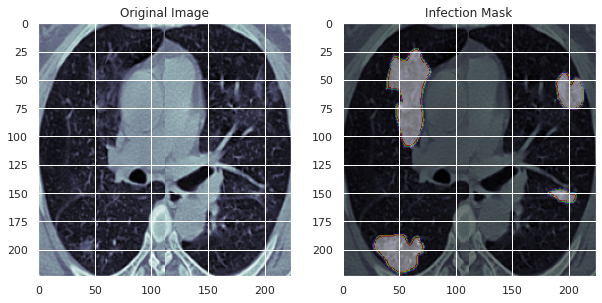

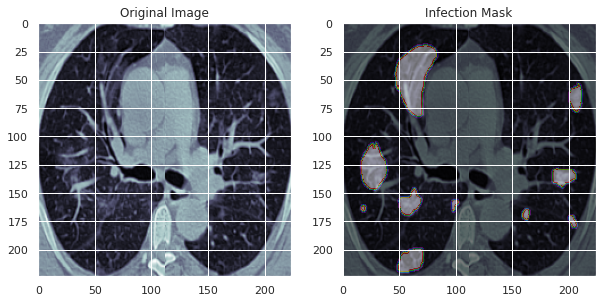

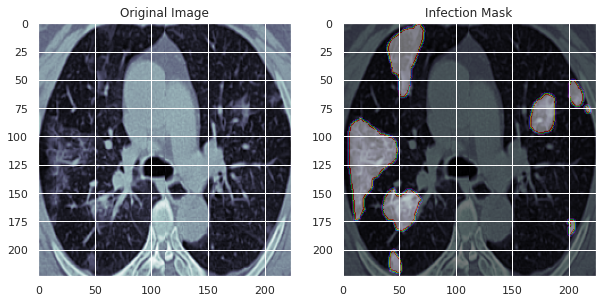

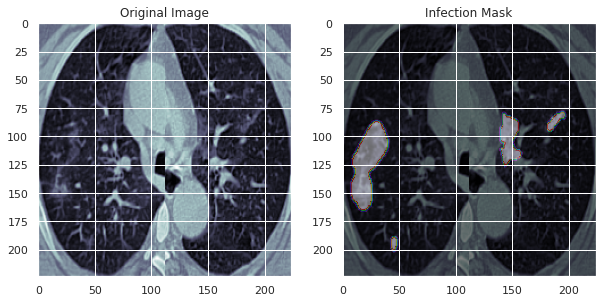

In [ ]:
for index in [100,110,120,130,140,150]:
    plot_sample([new_cts[index], new_infections[index]])

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(new_cts, new_infections, test_size=0.3, random_state=42)

In [ ]:
print(x_train.shape, x_valid.shape)

(1478, 224, 224, 1) (634, 224, 224, 1)


Loss functions and metrics

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

In [ ]:
inputs = Input((new_dim, new_dim, 1))
# s = Lambda(lambda x: x / 255) (inputs)

# def mish(inputs):
#     return inputs * tf.math.tanh(tf.math.softplus(inputs))
    
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.0005, eta_min=0.0001)

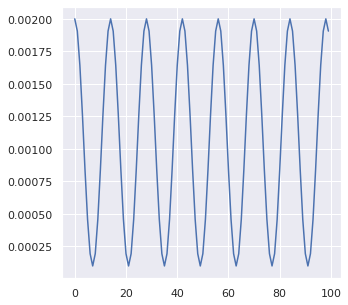

In [ ]:
rcParams['figure.figsize'] = 5,5
T_max=7
eta_max=0.002
eta_min = 0.0001
lr=[]
for epoch in range(100):    
    lr.append(eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2)
lr = np.array(lr)
plt.plot(lr)

In [ ]:
batch_size = 32
epochs = 80
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

In [ ]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Train on 1478 samples, validate on 634 samples
Epoch 1/80
1478/1478 [==============================] - 32s 22ms/step - loss: 0.4076 - dice_coeff: 0.3561 - val_loss: 1.1396 - val_dice_coeff: 7.5072e-05

Epoch 00001: val_dice_coeff improved from -inf to 0.00008, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 1.13963, saving model to unet_covid_weights_val_loss.hdf5
Epoch 2/80
1478/1478 [==============================] - 21s 14ms/step - loss: 0.2340 - dice_coeff: 0.6507 - val_loss: 1.0237 - val_dice_coeff: 8.6466e-05

Epoch 00002: val_dice_coeff improved from 0.00008 to 0.00009, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00002: val_loss improved from 1.13963 to 1.02370, saving model to unet_covid_weights_val_loss.hdf5
Epoch 3/80
1478/1478 [==============================] - 21s 14ms/step - loss: 0.1874 - dice_coeff: 0.7217 - val_loss: 0.8439 - val_dice_coeff: 6.0964e-04

Epoch 00003: val_dice_coeff improved from 0.00009 to 0.00

In [ ]:
gc.collect()

32

In [ ]:
model.load_weights(filepath_dice_coeff)

In [ ]:
model.save_weights('unet_lung_segmentation_0.9813.h5')

In [ ]:
files.download('unet_lung_segmentation_0.9813.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_json = model.to_json()
with open("unet_lung_segmentation_0.9813.json","w") as json_file:
     json_file.write(model_json)

files.download("unet_lung_segmentation_0.9813.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

634/634 [==============================] - 3s 4ms/step
test loss, test dice coefficient: [0.09137363734211455, 0.8762006759643555]


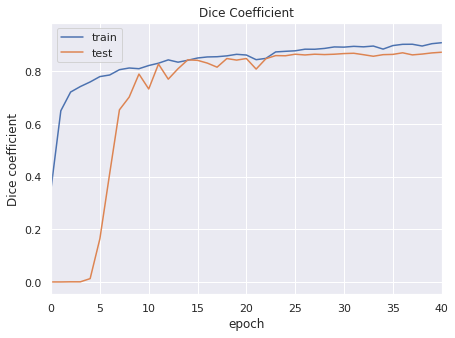

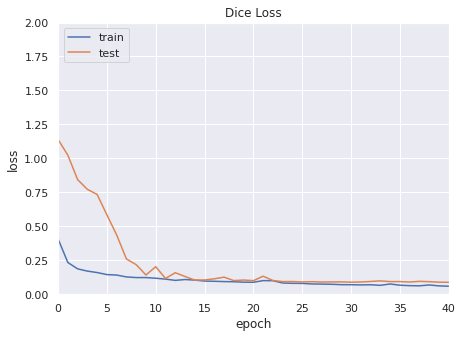

In [ ]:
plt.rcParams["axes.grid"] = True
rcParams['figure.figsize'] = 7, 5
plt.xlim(0, 40)
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 2)
plt.xlim(0, 40)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.rcParams["axes.grid"] = False

In [ ]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(new_cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(new_cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(new_infections[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()
    
# plt.imshow(temp.reshape(img_size, img_size), cmap = 'bone')
# plt.imshow(infections_scaled[120].reshape(img_size, img_size), cmap ='summer')

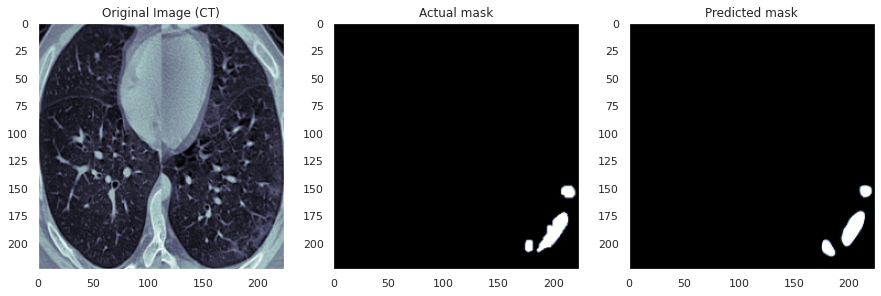

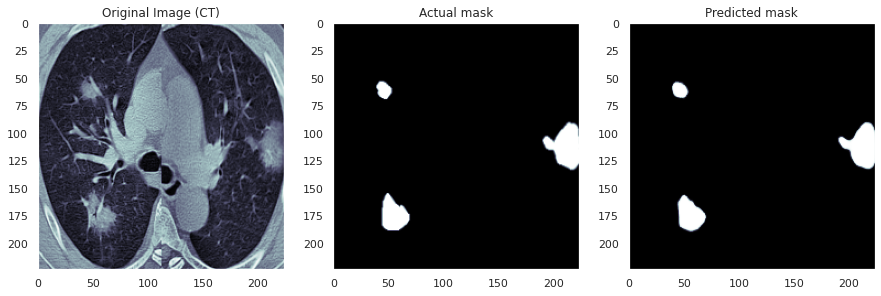

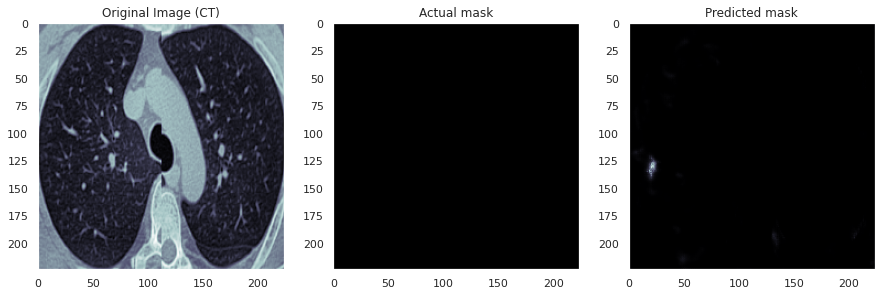

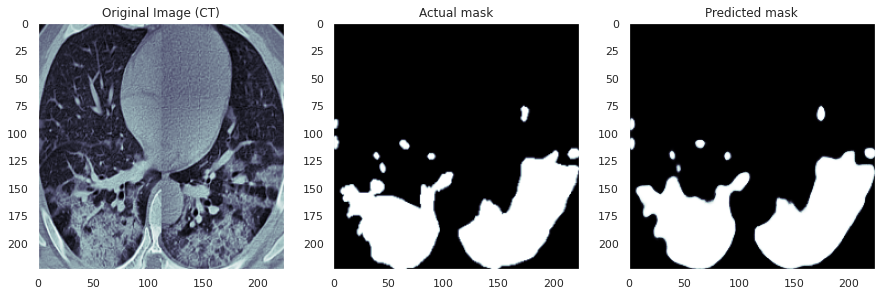

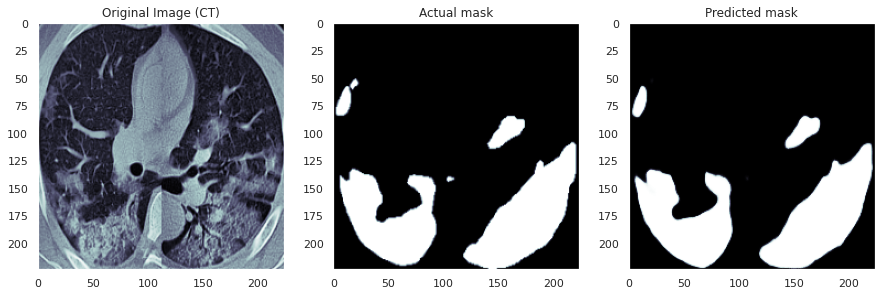

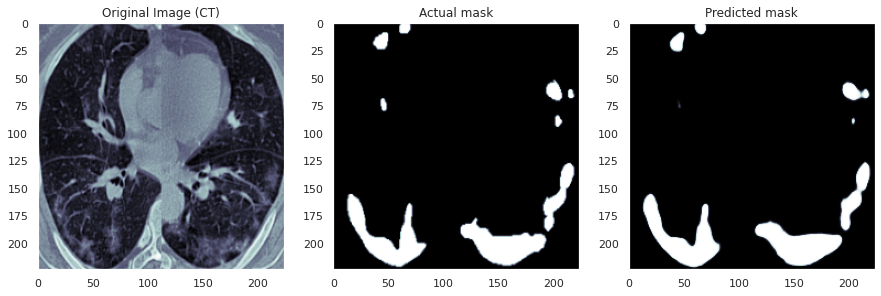

In [ ]:
for i in [440,269,555, 355, 380, 90]:
    compare_actual_and_predicted(i)

In [ ]:
gc.collect()

46152

# Some Significant Post-Processing

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_weights(filepath_dice_coeff)
#model.load_weights('/content/drive/My Drive/cts and infections/unet_lung_segmentation_0.9813.h5')

In [ ]:
the_range = np.arange(0.10,0.80, 0.05)

In [ ]:
dices=[]
ious=[]

for t in the_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

634/634 [==============================] - 3s 5ms/step


In [ ]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8762804269790649, 0.87754887342453, 0.8781701326370239, 0.8785360455513, 0.8787930607795715, 0.878964900970459, 0.8790351748466492, 0.8790943026542664, 0.8790980577468872, 0.8790701627731323, 0.8789936304092407, 0.8789256811141968, 0.8787202835083008, 0.8784761428833008]
IOUS: [0.7801460027694702, 0.7821604609489441, 0.7831538915634155, 0.7837342023849487, 0.7841444611549377, 0.7844189405441284, 0.7845333218574524, 0.784629762172699, 0.7846367955207825, 0.7845933437347412, 0.7844732403755188, 0.7843675017356873, 0.7840432524681091, 0.7836564779281616]
Best Threshold: 0.5000000000000001
Best dice score: 0.8790980577468872
Best iou score: 0.7846367955207825


Best Threshold: 0.5000000000000001


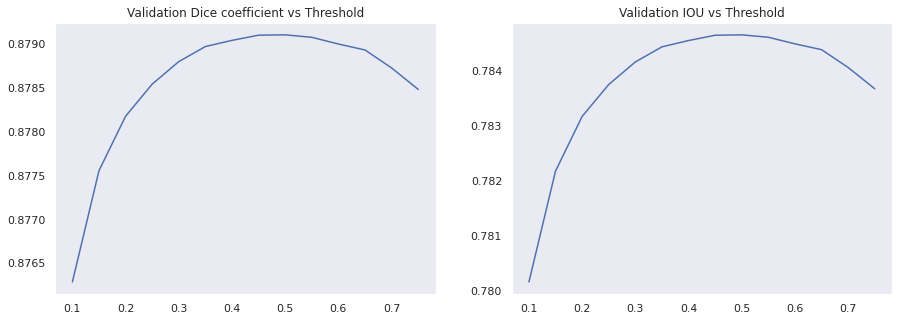

In [ ]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
the_new_range = np.arange(0.43,0.53, 0.001)

In [ ]:
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

634/634 [==============================] - 3s 5ms/step


In [ ]:
print("We just checked for",len(the_new_range), "steps between 0.39 and 0.47")

We just checked for 101 steps between 0.39 and 0.47


In [ ]:
print('NEW DICES:',new_dices)
print("NEW IOUS:",new_ious)
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

NEW DICES: [0.8790672421455383, 0.8790655136108398, 0.8790680170059204, 0.879071056842804, 0.8790731430053711, 0.8790777921676636, 0.8790808916091919, 0.8790825009346008, 0.8790815472602844, 0.879086971282959, 0.8790911436080933, 0.8790907859802246, 0.8790935277938843, 0.879095196723938, 0.8790968656539917, 0.8791010975837708, 0.8791021108627319, 0.8790988922119141, 0.8790915608406067, 0.879091739654541, 0.8790943026542664, 0.879097580909729, 0.8791001439094543, 0.8791022300720215, 0.8791044354438782, 0.8791061639785767, 0.8791068196296692, 0.8791061639785767, 0.8791035413742065, 0.8791066408157349, 0.8791046142578125, 0.879112720489502, 0.8791078329086304, 0.879107654094696, 0.879104495048523, 0.8791084289550781, 0.8791087865829468, 0.8791125416755676, 0.8791108131408691, 0.8791149258613586, 0.8791214823722839, 0.8791181445121765, 0.879116415977478, 0.8791186213493347, 0.8791166543960571, 0.8791082501411438, 0.879107654094696, 0.8791078329086304, 0.8791042566299438, 0.8791041374206543

Best Threshold: 0.47000000000000003


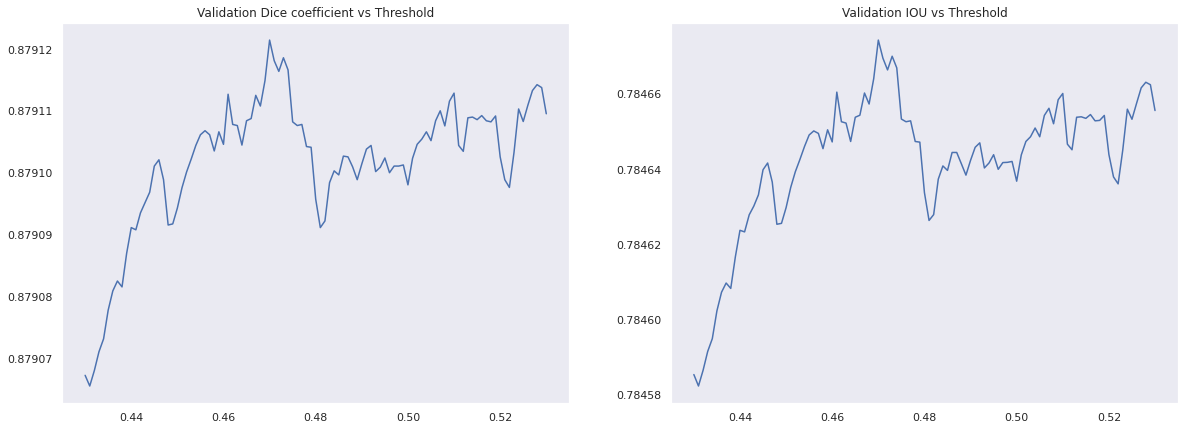

In [ ]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [ ]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])

634/634 [==============================] - 3s 5ms/step


In [ ]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

PRECISIONS: [0.05191034823656082, 0.8329013586044312, 0.8483093976974487, 0.8557842969894409, 0.8606545329093933, 0.864388108253479, 0.8675130009651184, 0.8701817393302917, 0.8726145029067993, 0.8749319911003113, 0.8771675229072571, 0.879469096660614, 0.8818008303642273, 0.8842377662658691, 0.8868230581283569, 0.8896811604499817, 0.8929985761642456, 0.8970733880996704, 0.9027589559555054, 0.912835419178009]
RRECALLS: [1.0, 0.9170361757278442, 0.906335711479187, 0.9006220102310181, 0.8965838551521301, 0.8933230638504028, 0.8905378580093384, 0.8880929946899414, 0.8857166171073914, 0.8834614753723145, 0.881202220916748, 0.8788371086120605, 0.8763706088066101, 0.873843789100647, 0.8709333539009094, 0.867718517780304, 0.8638003468513489, 0.858565628528595, 0.8508764505386353, 0.8356253504753113]
Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.912835419178009
Best recall score: 1.0


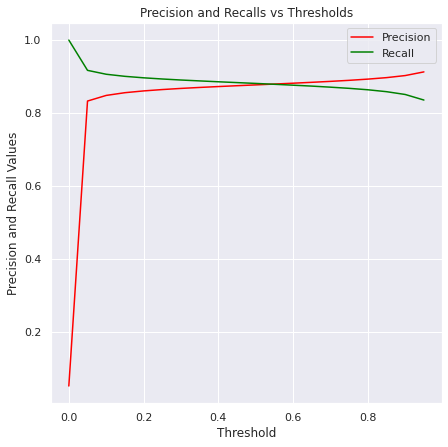

In [ ]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])